In [1]:
%matplotlib inline

In [35]:
import numpy as np
import scipy as sp
import pandas as pd
import nibabel as nib
import seaborn as sbn
from matplotlib import gridspec
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from statsmodels.sandbox.stats.multicomp import multipletests as stm

In [23]:
abide_16_p = '/home/users/surchs/abide_16p_similarity.tsv'
abide_22_p = '/home/users/surchs/abide_22q_similarity.tsv'
mist_64_p = '/home/users/surchs/GDrive/PhD/Paper/Multiscale_Atlas/Release/Parcellations/MIST_64.nii.gz'
labels_p = '/home/users/surchs/mnt/cedar_simrrg/ATLAS/MIST/Parcel_Information/MIST_64.csv'

In [4]:
mist64_i = nib.load(mist_64_p)
mist64 = mist64_i.get_data()

In [5]:
abide_16 = pd.read_csv(abide_16_p, sep='\t')
abide_22 = pd.read_csv(abide_22_p, sep='\t')

In [25]:
labels = pd.read_csv(labels_p, delimiter=';')

In [6]:
abide_16.shape

(672, 65)

In [7]:
con_idx = abide_16['DX_GROUP']=='Control'
n_con = np.sum(con_idx)
n_asd = np.sum(~con_idx)
pl_16 = list()
pid = list()
eff_l = list()
eff_ls_16 = list()
gt = list()
for col in list(abide_16.columns)[1:]:
    u_min, p = sp.stats.mannwhitneyu(abide_16.loc[~con_idx, col], abide_16.loc[con_idx, col], alternative=None)
    u_right, ppp = sp.stats.mannwhitneyu(abide_16.loc[~con_idx, col], abide_16.loc[con_idx, col], alternative='two-sided')
    eff = 1 - (2*u_min) / (n_asd*n_con)
    del_gt_con = u_right > u_min
    pl_16.append(p)
    if del_gt_con:
        eff_ls_16.append(eff)
    else:
        eff_ls_16.append(-eff)

In [8]:
dx_16 = np.where(stm(pl_16, alpha=0.05, method='fdr_bh')[0])[0]

In [9]:
dx_16

array([ 0,  3,  4, 12, 13, 16, 30, 33, 50, 51, 57])

In [12]:
abide16_vol = np.zeros(mist64.shape)
for eff_id in dx_16:
    abide16_vol[mist64==eff_id+1] = eff_ls_16[eff_id]
abide16_img = nib.Nifti1Image(abide16_vol, header=mist64_i.header, affine=mist64_i.affine)
nib.save(abide16_img, '/home/users/surchs/abide_16pDEL_map.nii.gz')

In [13]:
vbm_cuts = (-38, -20, 7)

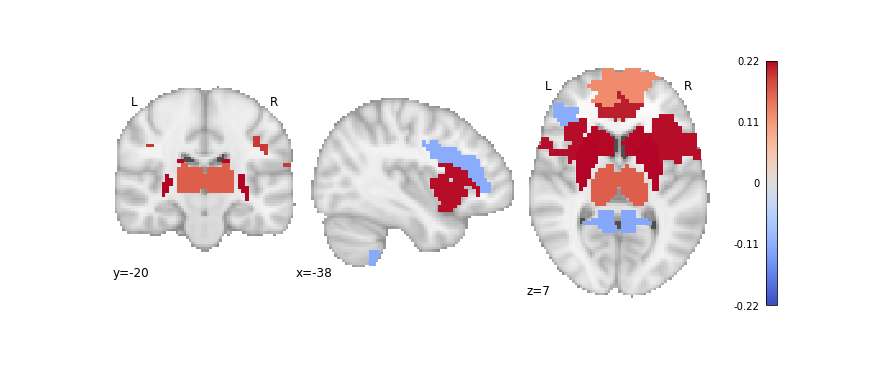

In [14]:
# And also plot it
f = plt.figure(figsize=(12,5), constrained_layout=True)
ax = f.add_subplot(111)
nlp.plot_stat_map(abide16_img, cut_coords=vbm_cuts, axes=ax, cmap=plt.cm.coolwarm, draw_cross=False, colorbar=True)
f.savefig('/home/users/surchs/abide_16pDEL_map.png', dpi=300, transparent=True)

# Now the same for 22q

In [15]:
con_idx = abide_22['DX_GROUP']=='Control'
n_con = np.sum(con_idx)
n_asd = np.sum(~con_idx)
pl_22 = list()
pid = list()
eff_l = list()
eff_ls_22 = list()
gt = list()
for col in list(abide_22.columns)[1:]:
    u_min, p = sp.stats.mannwhitneyu(abide_22.loc[~con_idx, col], abide_22.loc[con_idx, col], alternative=None)
    u_right, ppp = sp.stats.mannwhitneyu(abide_22.loc[~con_idx, col], abide_22.loc[con_idx, col], alternative='two-sided')
    eff = 1 - (2*u_min) / (n_asd*n_con)
    del_gt_con = u_right > u_min
    pl_22.append(p)
    if del_gt_con:
        eff_ls_22.append(eff)
    else:
        eff_ls_22.append(-eff)

In [16]:
dx_22 = np.where(stm(pl_22, alpha=0.05, method='fdr_bh')[0])[0]

In [17]:
dx_22

array([ 0,  3,  4,  8, 18, 20, 23, 24, 27, 33, 40, 41, 46, 47, 48, 52, 53,
       57])

In [18]:
abide22_vol = np.zeros(mist64.shape)
for eff_id in dx_22:
    abide22_vol[mist64==eff_id+1] = eff_ls_22[eff_id]
abide22_img = nib.Nifti1Image(abide22_vol, header=mist64_i.header, affine=mist64_i.affine)
nib.save(abide22_img, '/home/users/surchs/abide_22pDEL_map.nii.gz')

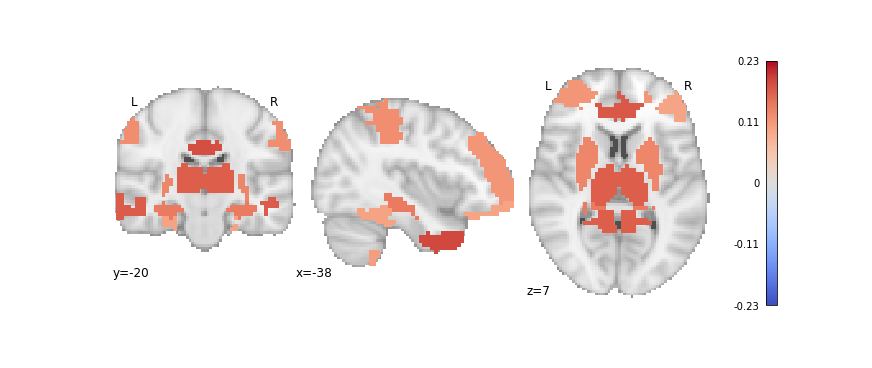

In [19]:
# And also plot it
f = plt.figure(figsize=(12,5), constrained_layout=True)
ax = f.add_subplot(111)
nlp.plot_stat_map(abide22_img, cut_coords=vbm_cuts, axes=ax, cmap=plt.cm.coolwarm, draw_cross=False, colorbar=True)
f.savefig('/home/users/surchs/abide_22qDEL_map.png', dpi=300, transparent=True)

# Show me the overlap

In [20]:
overlap_network  = list(set(list(dx_16)).intersection(list(dx_22)))

In [22]:
len(overlap_network)

5

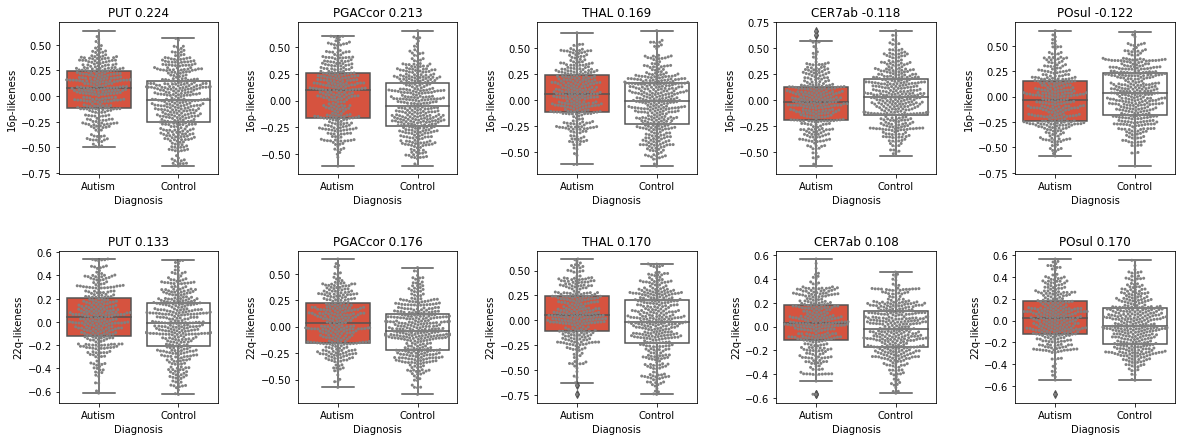

In [68]:
# We have 5 overlapping tests
f = plt.figure(figsize=(20,7))
gsp = gridspec.GridSpec(2, 5, hspace=0.5, wspace=0.5)
for fig_id, ind in enumerate(overlap_network):
    r_name = labels[labels['roi']==ind+1]['label'].values[0]
    ax1 = f.add_subplot(gsp[0, fig_id])
    ax2 = f.add_subplot(gsp[1, fig_id])

    # Get the top contributors
    top16 = np.percentile(abide_16.loc[abide_16['DX_GROUP']=='Autism'][r_name].values, 90)
    top22 = np.percentile(abide_22.loc[abide_22['DX_GROUP']=='Autism'][r_name].values, 90)
    abide_16['top22'] = (abide_16['DX_GROUP']=='Autism').values & (abide_22[r_name]>top16).values
    abide_22['top16'] = (abide_22['DX_GROUP']=='Autism').values & (abide_16[r_name]>top22).values
    
    sbn.boxplot(y=r_name, x='DX_GROUP', data=abide_16, ax=ax1, palette=sbn.xkcd_palette(['tomato', 'white']))
    sbn.swarmplot(y=r_name, x='DX_GROUP', data=abide_16, ax=ax1, size=3, color='grey')
    ax1.set_ylabel('16p-likeness')
    ax1.set_xlabel('Diagnosis')
    ax1.set_title('{} {:.3f}'.format(r_name, eff_ls_16[ind]))
    
    sbn.boxplot(y=r_name, x='DX_GROUP', data=abide_22, ax=ax2, palette=sbn.xkcd_palette(['tomato', 'white']))
    sbn.swarmplot(y=r_name, x='DX_GROUP', data=abide_22, ax=ax2, size=3, color='grey')
    ax2.set_ylabel('22q-likeness')
    ax2.set_xlabel('Diagnosis')
    ax2.set_title('{} {:.3f}'.format(r_name, eff_ls_22[ind]))
    
f.savefig('/home/users/surchs/16p22q_ABIDE_vanilla.png', dpi=300, bbox_inches='tight', pad_inches=0)

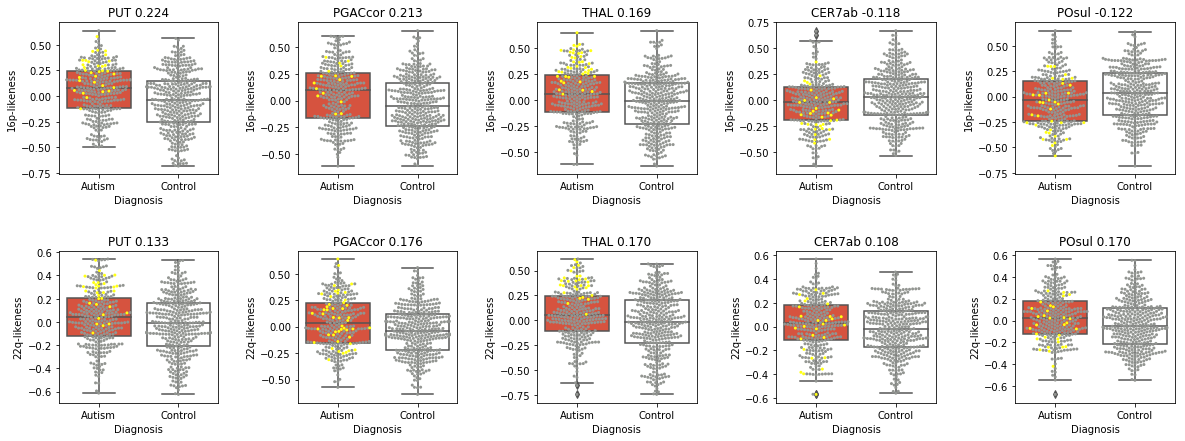

In [63]:
# We have 5 overlapping tests
f = plt.figure(figsize=(20,7))
gsp = gridspec.GridSpec(2, 5, hspace=0.5, wspace=0.5)
for fig_id, ind in enumerate(overlap_network):
    r_name = labels[labels['roi']==ind+1]['label'].values[0]
    ax1 = f.add_subplot(gsp[0, fig_id])
    ax2 = f.add_subplot(gsp[1, fig_id])

    # Get the top contributors
    top16 = np.percentile(abide_16.loc[abide_16['DX_GROUP']=='Autism'][r_name].values, 90)
    top22 = np.percentile(abide_22.loc[abide_22['DX_GROUP']=='Autism'][r_name].values, 90)
    abide_16['top22'] = (abide_16['DX_GROUP']=='Autism').values & (abide_22[r_name]>top16).values
    abide_22['top16'] = (abide_22['DX_GROUP']=='Autism').values & (abide_16[r_name]>top22).values
    
    sbn.boxplot(y=r_name, x='DX_GROUP', data=abide_16, ax=ax1, palette=sbn.xkcd_palette(['tomato', 'white']))
    sbn.swarmplot(y=r_name, x='DX_GROUP', data=abide_16, ax=ax1, color='yellow', size=3, hue='top22', palette=sbn.xkcd_palette(['grey', 'yellow']))
    ax1.legend_.remove()
    ax1.set_ylabel('16p-likeness')
    ax1.set_xlabel('Diagnosis')
    ax1.set_title('{} {:.3f}'.format(r_name, eff_ls_16[ind]))
    
    sbn.boxplot(y=r_name, x='DX_GROUP', data=abide_22, ax=ax2, palette=sbn.xkcd_palette(['tomato', 'white']))
    sbn.swarmplot(y=r_name, x='DX_GROUP', data=abide_22, ax=ax2, color='yellow', size=3, hue='top16', palette=sbn.xkcd_palette(['grey', 'yellow']))
    ax2.legend_.remove()
    ax2.set_ylabel('22q-likeness')
    ax2.set_xlabel('Diagnosis')
    ax2.set_title('{} {:.3f}'.format(r_name, eff_ls_22[ind]))
    
f.savefig('/home/users/surchs/16p22q_ABIDE_top_yellow.png', dpi=300, bbox_inches='tight', pad_inches=0)

0.35108698272482286